# 使用shapefile设定pcolormesh的绘制区域

以MODIS NDVI产品为例, 条带号为H27V5。边界限制为河南省。

## 导入库

In [2]:
import matplotlib
import cartopy.crs as ccrs
from pyhdf.SD import SD, SDC
import matplotlib.pyplot as plt
from matplotlib.path import Path
from cartopy.io import shapereader
from pyresample import create_area_def
from cartopy.mpl.patch import geos_to_path

## 定义MODIS 数据瓦片区域，得到每个网格的经纬度

In [3]:
h27v5_area = create_area_def(
    units="m",
    width=1200,
    height=1200,
    area_id="modis-h27v5",
    projection="+proj=sinu +R=6371007.181",
    area_extent=["1.0007554677e7", '3335851.559', "1.1119505196667e7", "4447802.078667"]
)
h27v5_lon, h27v5_lat = h27v5_area.get_lonlats()

## 加载shp文件，并生成path对象

In [4]:
shp_file = "/home/xueke/GeoDatasets/HeNanShape/HeNan.shp"
shp_obj = shapereader.Reader(shp_file)
path = Path.make_compound_path(*geos_to_path(list(shp_obj.geometries())))

## 定义色标

In [5]:
cmap = matplotlib.cm.get_cmap("Greens")
norm = matplotlib.colors.Normalize(0, 1)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

## 读取NDVI数据

In [6]:
ndvi_file = "MOD13A3.A2022335.h27v05.006.2023005033509.hdf"
hdf_obj = SD(ndvi_file, SDC.READ)
ndvi_ds = hdf_obj.select("1 km monthly NDVI")
ndvi_data = ndvi_ds.get() * 0.0001

## 绘图

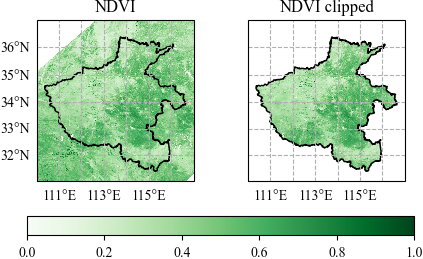

<Figure size 640x480 with 0 Axes>

In [7]:
# 创建画布
coord_crs = ccrs.PlateCarree()
map_crs = ccrs.Mercator(central_longitude=105)
fig = plt.figure(figsize=(5,3))
ax1 = fig.add_subplot(1, 2, 1, projection=map_crs)
ax2 = fig.add_subplot(1, 2, 2, projection=map_crs, sharex=ax1, sharey=ax1)
ax1.set_title("NDVI")
ax2.set_title("NDVI clipped")
ax1.set_extent([110, 117, 31, 37], crs=coord_crs)
ax2.set_extent([110, 117, 31, 37], crs=coord_crs)
ax1.gridlines(draw_labels=["left", "bottom"], linestyle='--')
ax2.gridlines(draw_labels=["bottom"], linestyle='--')

## 绘制Shapefile
shp_crs = ccrs.PlateCarree()
ax1.add_geometries(shp_obj.geometries(), crs=shp_crs, facecolor="None")
ax2.add_geometries(shp_obj.geometries(), crs=shp_crs, facecolor="None")

## 绘制数据
ax1.pcolormesh(h27v5_lon, h27v5_lat, ndvi_data, transform=coord_crs, cmap=cmap, norm=norm)
img = ax2.pcolormesh(h27v5_lon, h27v5_lat, ndvi_data, transform=coord_crs, cmap=cmap, norm=norm)
img.set_clip_path(path, transform=shp_crs._as_mpl_transform(ax2))

fig.colorbar(mappable, ax=[ax1,ax2], orientation='horizontal')
plt.show()